# Discrete-Time Consensus in MAS

#### Per questo laboratiorio vengono creati dei Robot puntiformi disposti casualmente nello spazio bidimensionale e viene implementato l'algoritmo del consenso che porta i robot a convergere tutti nello stesso punto, risolvendo il problema di sincronzzazione e distributed averaging. Nello spazio sono presenti anche due ostacoli che i Robot devono evitare.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
class Robot:
    def __init__(self, i, x, y, neighs=None):
        self.i = i
        self.x = x
        self.y = y
        self.neighs = set()
        
    def get_degree(self):
        return len(self.neighs)
    
    def add_neighbor(self, r, radius):
            dist = math.sqrt( (self.x - r.x)**2 + (self.y - r.y)**2 )
            if dist <= radius and r not in self.neighs and r is not self:
                self.neighs.add(r)


In [3]:
class Obstacle():
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

In [4]:
sns.set_theme()

X_RANGE = 500
Y_RANGE = 300
N_ROBOTS = 20
max_iter = 800
D0 = 100 #distanza di rilevanza
D = 20 #distanza di sicurezza
robots = []
data=[]

#Crezione ostacoli
obs1 = Obstacle(int(0.3*X_RANGE), int(0.8*Y_RANGE), radius=30)
obs2 = Obstacle(int(0.8*X_RANGE), int(0.3*Y_RANGE), radius=60)
obstacles = set((obs1, obs2))


def in_obstacle(obs, x, y): #check se un punto di coordinate (x,y) è all'interno dell'ostacolo
    square_dist = (obs.x - x)**2 + (obs.y - y)**2
    return square_dist <= (obs.radius + D) ** 2 #i robot dovranno essere generati al di fuori dell'area di sicurezza
    
#Creazione robot
for n in range(N_ROBOTS):
    x = random.randint(0,X_RANGE)
    y = random.randint(0,Y_RANGE)
    while in_obstacle(obs1, x, y) or in_obstacle(obs2, x, y): #se il punto è all'interno dell'area di sicurezza, si continua a generare randomicamente
        x = random.randint(0, X_RANGE)
        y = random.randint(0, Y_RANGE)
    r = Robot(n, x, y)
    data.append((r.x, r.y)) 
    robots.append(r)
    
centroid=np.mean(data, axis=0)
print(centroid)

[269.4  157.15]


> Creiamo i robot definendo le dimensioni dello spazio `X_RANGE` e `Y_RANGE`. Le posizioni sono generate randomicamente, controllando che siano ogni volta al di fuori dell'area di sicurezza degli ostacoli.
Per il problema di `distributed averaging` i robot andranno a convergere nel baricentro delle loro posizioni iniziali, quindi questo viene calcolato a priori per verificare poi la correttezza dell'algoritmo.

In [5]:
def draw_obstacles(obstacles, axes):
    for obs in obstacles:
        circle = plt.Circle((obs.x, obs.y), obs.radius)
        security = plt.Circle((obs.x, obs.y), obs.radius + D, alpha=0.3)
        visibility = plt.Circle((obs.x, obs.y), obs.radius + D0, alpha=0.2)
        axes.add_artist(circle)
        axes.add_artist(security)
        axes.add_artist(visibility)



def draw_graph(robots):
    figure, axes = plt.subplots() 
    plt.axis('equal')
    #axes.set_aspect(1)
    for r in robots:
        plt.plot(r.x, r.y, 'ro', markersize=5)
        plt.annotate(r.i, (r.x, r.y), color='indianred', alpha=0.7, fontsize='11')
        for rr in robots:
            if r in rr.neighs or rr in r.neighs:
                plt.plot([r.x, rr.x], [r.y, rr.y], linestyle='dashed', color='coral', linewidth=0.3, alpha=0.6)
    
    draw_obstacles(obstacles, axes)
    
    plt.plot(centroid[0], centroid[1], 'go', markersize=5, alpha=0.4)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Robots configuration")
    plt.show()

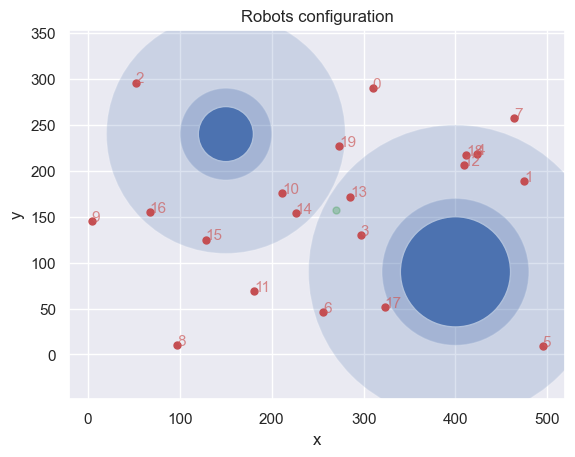

In [6]:
draw_graph(robots)

> Posizione iniziale dei robot identificati da un id

In [7]:
def laplacian(robots):
    laplacian = np.zeros((N_ROBOTS, N_ROBOTS))
    for r in robots:
        for rr in robots:
            if r in rr.neighs or rr in r.neighs:
                laplacian[r.i][rr.i] = -1
            laplacian[r.i][r.i] = r.get_degree()
    return laplacian  

In [8]:
def cons_matr_def(robots, eps): #default
    cons_matr = np.zeros((N_ROBOTS, N_ROBOTS))
    for r in robots:
        for rr in robots:
            if r in rr.neighs or rr in r.neighs:
                cons_matr[r.i][rr.i] = eps
            cons_matr[r.i][r.i] = 1 - eps*(r.get_degree())
    return cons_matr

In [9]:
def is_fully_connected(robots):
    if any(r.get_degree() != N_ROBOTS - 1 for r in robots):
        return False
    else:
        return True

def is_connected(robots):
    L = laplacian(robots)
    eigs = np.linalg.eigvals(L)
    eigs.sort()
    if math.floor(eigs[1]) > 0:
        return True
    else:
        return False

    
def get_max_degree(robots):
    if is_fully_connected(robots):
        dmax = N_ROBOTS - 1
    elif is_connected(robots):
        dmax = max(len(r.neighs) for r in robots)
    else:
        print("Not connected! Can't calculate degree")
        dmax=0
    return dmax


def get_average_degree(robots):
    davg = (1/N_ROBOTS) * sum(r.get_degree() for r in robots)
    return davg

In [10]:
def create_connected_graph(robots, radius):
    for r in robots:
        for rr in robots:
            r.add_neighbor(rr, radius=radius)
    if is_connected(robots):
        return robots
    else:
        radius+=10
        create_connected_graph(robots, radius)
        
def create_fully_connected_graph(robots, radius):
    for r in robots:
        for rr in robots:
            r.add_neighbor(rr, radius=radius)
    if is_fully_connected(robots):
        return robots
    else:
        radius+=10
        create_fully_connected_graph(robots, radius)          

>Viene creato un grafo che connette i robot vicini tra di loro. I robot possono accedere alle informazioni sulla posizione solo dei propri neighbors.

>Se la distanza tra i robot è inferiore rispetto ad un raggio 'radius' dato, allora viene creato un arco tra essi, altrimenti il raggio viene aumentato finché il grafo non è connesso.
>E' possibile creare un grafo completamente connesso, in cui tutti i nodi sono collegati tra di loro da un collegamento diretto.

In [11]:
def cons_matr_uniform(robots):
    cons_matr = np.zeros((N_ROBOTS, N_ROBOTS))
    for r in robots:
        for rr in robots:
            if r in rr.neighs or rr in r.neighs:
                cons_matr[r.i][rr.i] = (1 / (r.get_degree()+1) )
            cons_matr[r.i][r.i] = (1 / (r.get_degree()+1) )
    return cons_matr

def cons_matr_metropolis(robots):
    cons_matr = np.zeros((N_ROBOTS, N_ROBOTS))
    for r in robots:
        for rr in robots:
            if r in rr.neighs or rr in r.neighs:
                cons_matr[r.i][rr.i] = (1 / max( r.get_degree(), rr.get_degree() ))
                cons_matr[r.i][r.i] = 0
        cons_matr[r.i][r.i] = 1 - sum(cons_matr[r.i])
    return cons_matr

#### La matrice del consenso $\Pi$ permette di calcolare lo step e le nuove coordinate di ogni robot ad ogni istante di tempo, secondo la formula:

### $x_{i}(t+1) = \pi_{ii}x_{i}(t) + \sum \limits _{j\in \mathcal{N}_{i}} \pi_{ij}x_{j}$

#### dove $\mathcal{N}_{i}$ indica l'insime dei vicini (neighbors) di $x_{i}$.
#### Per questa esercitazione abbiamo utilizzato la versione di 'default' della matrice del consenso, definita in questo modo:

### $ \Pi_{ij} = \begin{cases} 1-ϵ d_{i}  & \text{se} & j=i\\ \epsilon & \text{se} & j\in\mathcal{N}_{i} \\ 0 & \text{altrimenti}\\ \end{cases} $

#### dove $d_{i}$ è il grado del robot i-esimo, ovvero il suo numero di vicini, e $ϵ$ è un parametro globale $0 < ϵ < \frac{1}{d_{max}}$


#### Vengono lasciate inoltre le implementazioni delle matrici secondo i pesi uniformi e i pesi di metropolis, che non utilizzano il parametro globale $ϵ$

##### Pesi Uniformi: $ \Pi_{ij} = \begin{cases} \frac{1}{d_{i} + 1} & \text{se} & j\in\mathcal{N}_{i} & \text{o} & j=i\\ 0 & \text{altrimenti}\\ \end{cases} $



##### Pesi Metropolis:  $ \Pi_{ij} = \begin{cases} \frac{1}{1+\max \{d_{i},d_{j}\}} & \text{se} & j\in\mathcal{N}_{i}\\ 1 - \sum \limits _{j\in\mathcal{N}_{i}} & \text{se} & j=i\\ 0 & \text{altrimenti} \end{cases} $


C:\Users\nenec\AppData\Local\Temp\ipykernel_5908\1946517434.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.floor(eigs[1]) > 0:


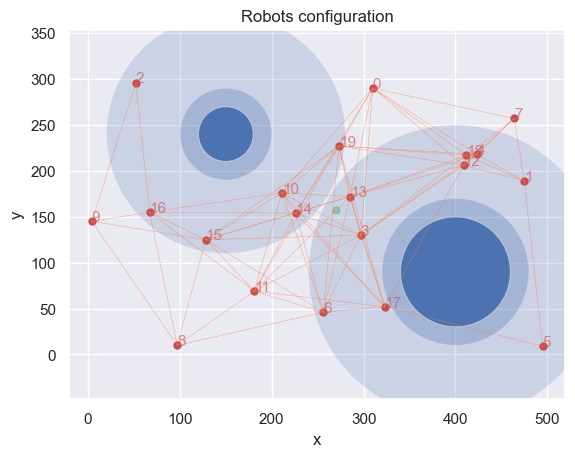


 Max degree:  12


In [12]:
create_connected_graph(robots, radius=15)
draw_graph(robots)
print("\n Max degree: ", get_max_degree(robots))

eps = ( (1/get_max_degree(robots)) / 10 )  
#eps = 0.05

cons_matr = cons_matr_def(robots, eps)

In [13]:
import sympy

def repulsive_grad(robot, obs):
    x, y = sympy.symbols('x y')
    dist = math.sqrt((robot.x - obs.x) ** 2 + (robot.y - obs.y) ** 2) - obs.radius
    if dist < D0:
        symbdist = sympy.sqrt((x - obs.x) ** 2 + (y - obs.y) ** 2) - obs.radius
        f = 0.5 * ((1 / (symbdist - D)) - (1 / (D0 - D))) ** 2
        dfX = sympy.diff(f, x)
        resultX = dfX.subs(x, robot.x).subs(y, robot.y)
        dfY = sympy.diff(f, y)
        resultY = dfY.subs(x, robot.x).subs(y, robot.y)
        return resultX.evalf(), resultY.evalf()
    else:
        return 0, 0

In [14]:
def consenus_update(robot, cons_matr):
    updatex = cons_matr[robot.i][robot.i] * robot.x
    updatey = cons_matr[robot.i][robot.i] * robot.y
    for rr in robot.neighs:
        updatex += cons_matr[robot.i][rr.i] * rr.x
        updatey += cons_matr[robot.i][rr.i] * rr.y
    cons_coords = [updatex, updatey]
    return cons_coords

def step_update(robots, cons_coords, k, max_step=50):
    for r in robots:
        repulsivex1, repulsivey1 = repulsive_grad(r, obs1)
        repulsivex2, repulsivey2 = repulsive_grad(r, obs2)
               
        updatex = cons_coords[r.i][0] - k*repulsivex1 - k*repulsivex2
        updatey = cons_coords[r.i][1] - k*repulsivey1 - k*repulsivey2
      
        dist = math.sqrt((updatex - r.x)**2 + (updatey - r.y)**2)
        
        if (dist >= max_step):
            cosa = (updatex - r.x) / dist
            sina = (updatey - r.y) / dist
            r.x = (cosa * max_step) + r.x
            r.y = (sina * max_step) + r.y
        else:
            r.x = updatex
            r.y = updatey
            
    return robots

#### Lo step effettivo viene calcolato utilizzando la formula del consenso e il potenziale repulsivo dato dalla presenza degli ostacoli.
#### Il potenziale repulsivo $J_{rep, k}(q)$ per un robot q e riferito all'ostacolo $O_k$ è:

### $ J_{rep,k}(q) = \begin{cases} 0  & \text{se} & d(q, O_k) \geq δ_0 \\ \frac{1}{2}(\frac{1}{d(q, O_k) - δ} - \frac{1}{δ_0 - δ})^2 & \text{se} & d(q, O_k) < δ_0 \\ \end{cases} $

#### dove $δ_0$ è la distanza di rilevanza e $δ$ è quella di sicurezza.

#### Quindi in conclusione, la posizione del robot sarà data da:

### $x_{i}(t+1) = \pi_{ii}x_{i}(t) + \sum \limits _{j\in \mathcal{N}_{i}} \pi_{ij}x_{j} - k \frac{\partial J(q)}{\partial q_i}\Bigr|_{\substack{q=q(t)}}$

#### Nel caso in cui lo step, ovvero la distanza tra $x_i(t)$ e $x_i(t+1)$, superi la soglia massima di `max_step`, questa viene imposta a `max_step`. Questo per rendere più realistico l'esperimento, ed evitare che i robot si muovano "troppo velocemente" in un singolo istante di tempo.

In [15]:
routes = np.zeros(((N_ROBOTS, max_iter, 2)))

k = 100

for t in range(max_iter):
    new_coords = []
    for r in robots:
        new_coords.append(consenus_update(r, cons_matr)) #aggiornamento coordinate
        routes[r.i][t] = [r.x, r.y]
    robots = step_update(robots, new_coords, k) #aggiornamento robot


> Viene creato un vettore routes che tiene conto di tutti i percorsi di tutti i robot per ogni istante di tempo, iterando la funzione `step_update` per un numero di volte fino al massimo delle iterazioni.

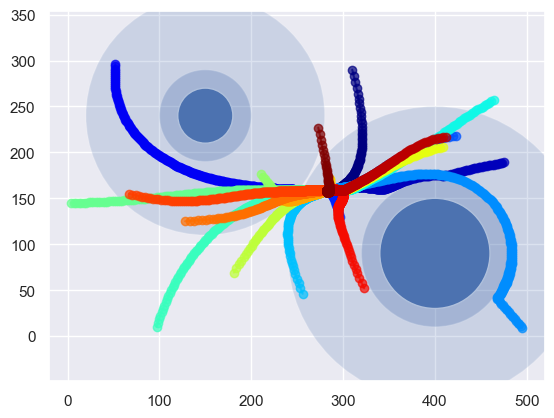

In [28]:
from matplotlib.pyplot import cm

figure, axes = plt.subplots() 
plt.axis('equal')
color = iter(cm.jet(np.linspace(0.0, 1.0, N_ROBOTS)))
for r in routes:
    plt.plot(r.transpose()[0], r.transpose()[1], marker='o', color=next(color), alpha=0.7)

draw_obstacles(obstacles, axes)

plt.show()

>Ogni colore rappresenta un robot diverso e la sua traiettoria nel tempo.

In [17]:
def check_if_synched():
    synch = True
    for r in robots:
        if (round(routes[r.i][max_iter-1][0]) != round(routes[0][max_iter-1][0]) and round(routes[r.i][max_iter-1][1]) != round(routes[0][max_iter-1][1])):
            synch = False
            return synch, "Not enough iterations..."    
    else:
        return synch, routes[0][max_iter-1] 
    
print("Synch Point: ", check_if_synched())
print("Centroid ", centroid)

Synch Point:  (True, array([282.46667255, 159.53322278]))
Centroid  [269.4  157.15]


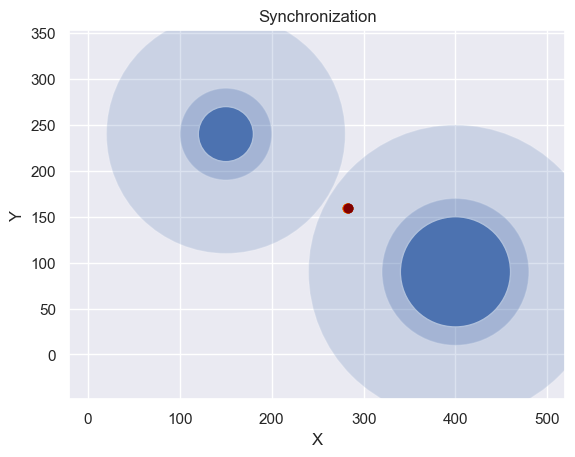

In [29]:
#% matplotlib widget
from matplotlib.animation import PillowWriter

color = iter(cm.jet(np.linspace(0.0, 1.0, N_ROBOTS)))

fig, axes = plt.subplots()
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")

draw_obstacles(obstacles, axes)

plt.title("Synchronization")

lines = []
for idx in range(N_ROBOTS):
    line, = plt.plot(routes[idx].transpose()[0], routes[idx].transpose()[1], marker='o', color=next(color))
    lines.append(line,)


writer = PillowWriter(fps=10)

with writer.saving(fig, "robotsynch.gif", 100):
    for idx in range(max_iter):
        for l in lines:
            x_data = []
            y_data = []
            i = lines.index(l)
            x_data.append(routes[i].transpose()[0][idx])
            y_data.append(routes[i].transpose()[1][idx])
        
            l.set_data(x_data, y_data)
        
        writer.grab_frame()


>Viene creata una GIF che mostra lo spostamento dei robot nel tempo.